# Championship 2024/25 – Standard Stats: Progression vs G+A per 90 (Forwards Only)

This notebook uses the **standard FBRef player stats** table:

- `data/curated/player_stats_semantic_2024_25.csv`

We focus on **forwards (FW)** with **G+A ≥ 10** and define:

- **Progression** = progressive carries + progressive passes + progressive passes received  
  \[
  \text{progression} = prgc + prgp + prgr
  \]

- **Progression per 90** = progression / 90s  
- **Output per 90** = G+A per 90 (`p90_g+a`)

The scatter plot shows:

- **x-axis**: progression per 90  
- **y-axis**: G+A per 90  
- **dot size**: total G+A (`g+a`)  
- **colour**: club  
- **diagonal reference line**:  
  \[
  y = x \times \frac{\text{median p90\_g+a}}{\text{median progression\_p90}}
  \]

Players **above the line** are turning progression into G+A more efficiently than the league norm;  
players **below the line** are high-progressors with lower final output.


In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Plot style
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

# ------------------------------------------------------------------
# Detect project root (directory that contains the "data" folder)
# ------------------------------------------------------------------
CWD = Path(os.getcwd())

if (CWD / "data").exists():
    PROJECT_ROOT = CWD
elif (CWD.parent / "data").exists():
    PROJECT_ROOT = CWD.parent
else:
    raise RuntimeError("Could not find project root (missing 'data/' folder).")

print("Project root:", PROJECT_ROOT)

DATA_DIR = PROJECT_ROOT / "data"
CURATED_DIR = DATA_DIR / "curated"

CURATED_DIR


Project root: /Users/FelixM/Documents/Work/Football/Swansea/mini-championship-pipeline


PosixPath('/Users/FelixM/Documents/Work/Football/Swansea/mini-championship-pipeline/data/curated')

In [2]:
std_path = CURATED_DIR / "player_stats_semantic_2024_25.csv"
print("Loading:", std_path)

df = pd.read_csv(std_path)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Loading: /Users/FelixM/Documents/Work/Football/Swansea/mini-championship-pipeline/data/curated/player_stats_semantic_2024_25.csv
Shape: (765, 37)
Columns: ['club_id', 'club', 'player_name', 'nationality', 'position', 'age', 'born', 'mp', 'starts', 'min', '90s', 'gls', 'ast', 'g+a', 'g-pk', 'pk', 'pkatt', 'crdy', 'crdr', 'xg', 'npxg', 'xag', 'npxg+xag', 'prgc', 'prgp', 'prgr', 'p90_gls', 'p90_ast', 'p90_g+a', 'p90_g-pk', 'p90_g+a-pk', 'p90_xg', 'p90_xag', 'p90_xg+xag', 'p90_npxg', 'p90_npxg+xag', 'matches']


,club_id,club,player_name,nationality,position,age,born,mp,starts,min,...,p90_ast,p90_g+a,p90_g-pk,p90_g+a-pk,p90_xg,p90_xag,p90_xg+xag,p90_npxg,p90_npxg+xag,matches
0,8,Leeds United,Brenden Aaronson,United States,MF,23.0,2000.0,46,43,3551,...,0.05,0.28,0.23,0.28,0.29,0.14,0.43,0.29,0.43,https://fbref.com/en/players/5bc43860/matchlog...
1,9,Luton Town,Thelo Aasgaard,Norway,"MF,FW",22.0,2002.0,17,17,1513,...,0.06,0.18,0.12,0.18,0.19,0.07,0.25,0.19,0.25,https://fbref.com/en/players/c88a28b9/matchlog...
2,23,Watford,James Abankwah,Republic of Ireland,DF,20.0,2004.0,19,17,1384,...,0.00,0.00,0.00,0.00,0.01,0.02,0.02,0.01,0.02,https://fbref.com/en/players/4b7a9fcc/matchlog...
3,21,Sunderland,Salis Abdul Samed,Ghana,MF,24.0,2000.0,10,3,283,...,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.01,https://fbref.com/en/players/82464ce3/matchlog...
4,22,Swansea City,Azeem Abdulai,Scotland,"FW,MF",21.0,2002.0,17,2,348,...,0.00,0.26,0.26,0.26,0.11,0.05,0.16,0.11,0.16,https://fbref.com/en/players/a0893a41/matchlog...


In [3]:
# ---------------------------------------------------------
# Filter: forwards only (FW) and G+A >= 10
# ---------------------------------------------------------
required = ["position", "g+a", "90s", "p90_xg", "p90_xag", "p90_g+a"]
missing = [c for c in required if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Forwards only
df_fw = df[df["position"].str.contains("FW", na=False)].copy()

# Minimum attacking return
df_fw = df_fw[df_fw["g+a"] >= 10].copy()

# Optional: minimum minutes (~5 full games)
# df_fw = df_fw[df_fw["90s"] >= 5].copy()

print("Forwards with G+A >= 10:", len(df_fw))

# ---------------------------------------------------------
# Compute expected and actual per 90
# ---------------------------------------------------------
df_fw["p90_xg_xag"] = df_fw["p90_xg"] + df_fw["p90_xag"]   # expected contribution
df_fw["p90_ga"] = df_fw["p90_g+a"]                         # actual contribution

df_fw[["club", "player_name", "position", "g+a", "p90_xg", "p90_xag", "p90_xg_xag", "p90_ga"]].head()


Forwards with G+A >= 10: 47


,club,player_name,position,g+a,p90_xg,p90_xag,p90_xg_xag,p90_ga
25,Burnley,Jaidon Anthony,"FW,MF",15,0.23,0.20,0.43,0.37
38,Middlesbrough,Finn Azaz,"MF,FW",23,0.24,0.25,0.49,0.58
62,Watford,Vakoun Bayo,FW,10,0.53,0.03,0.56,0.40
81,Portsmouth,Colby Bishop,FW,14,0.48,0.07,0.55,0.48
107,Burnley,Josh Brownhill,"MF,FW",24,0.26,0.12,0.38,0.62


In [4]:
# Build a colour per club for plotting
clubs = df_fw["club"].astype(str).unique()
clubs_sorted = np.sort(clubs)

cmap = plt.get_cmap("tab20")
num_colors = cmap.N

club_to_color = {
    club: cmap(i % num_colors)
    for i, club in enumerate(clubs_sorted)
}

club_to_color


{'Blackburn Rovers': (np.float64(0.12156862745098039),
  np.float64(0.4666666666666667),
  np.float64(0.7058823529411765),
  np.float64(1.0)),
 'Bristol City': (np.float64(0.6823529411764706),
  np.float64(0.7803921568627451),
  np.float64(0.9098039215686274),
  np.float64(1.0)),
 'Burnley': (np.float64(1.0),
  np.float64(0.4980392156862745),
  np.float64(0.054901960784313725),
  np.float64(1.0)),
 'Cardiff City': (np.float64(1.0),
  np.float64(0.7333333333333333),
  np.float64(0.47058823529411764),
  np.float64(1.0)),
 'Coventry City': (np.float64(0.17254901960784313),
  np.float64(0.6274509803921569),
  np.float64(0.17254901960784313),
  np.float64(1.0)),
 'Derby County': (np.float64(0.596078431372549),
  np.float64(0.8745098039215686),
  np.float64(0.5411764705882353),
  np.float64(1.0)),
 'Leeds United': (np.float64(0.8392156862745098),
  np.float64(0.15294117647058825),
  np.float64(0.1568627450980392),
  np.float64(1.0)),
 'Luton Town': (np.float64(1.0),
  np.float64(0.5960784313

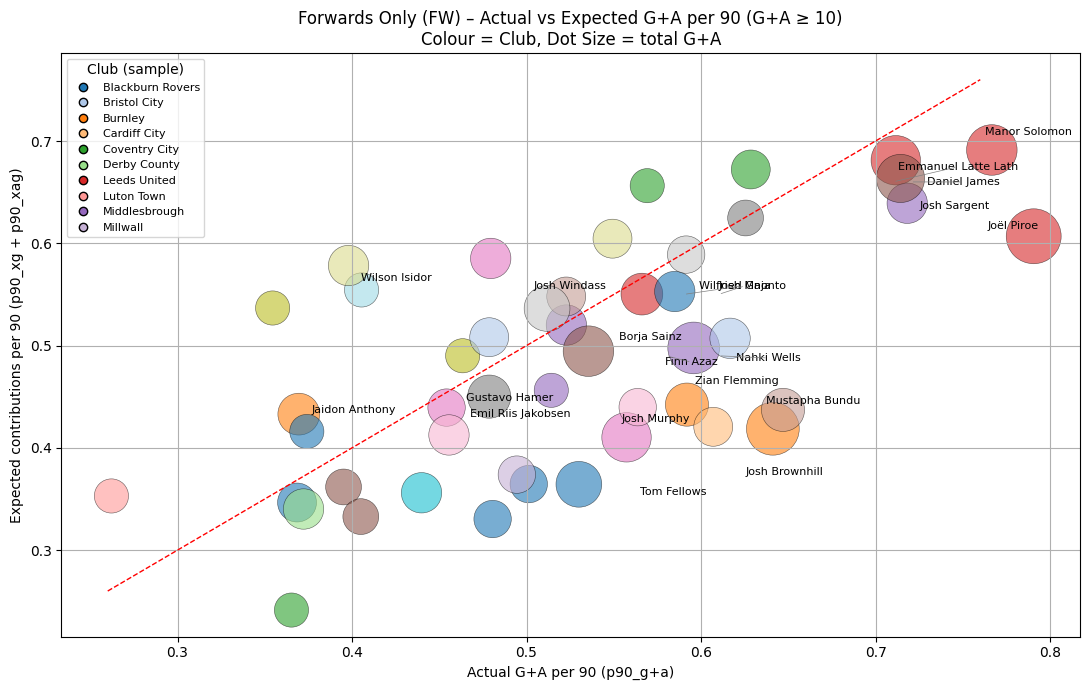

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text

df_plot = df_fw.copy()

# --- Safety check ---
required_plot = ["p90_xg_xag", "p90_ga", "g+a", "club", "player_name"]
missing_plot = [c for c in required_plot if c not in df_plot.columns]
if missing_plot:
    raise ValueError(f"Missing columns for plotting: {missing_plot}")

plt.figure(figsize=(11, 7))

# --- Dot sizes (total G+A) ---
size_factor = 60
sizes = (df_plot["g+a"].fillna(0) + 0.1) * size_factor

# --- Colours by club ---
colors = df_plot["club"].map(club_to_color)

# ============================
# JITTER IMPLEMENTATION
# ============================
jitter_x = 0.015
jitter_y = 0.015

# *** AXES SWAPPED HERE ***
x_jittered = df_plot["p90_ga"] + np.random.normal(0, jitter_x, len(df_plot))
y_jittered = df_plot["p90_xg_xag"] + np.random.normal(0, jitter_y, len(df_plot))

plt.scatter(
    x_jittered,
    y_jittered,
    s=sizes,
    c=colors,
    alpha=0.6,
    edgecolor="k",
    linewidth=0.4,
)

plt.xlabel("Actual G+A per 90 (p90_g+a)")
plt.ylabel("Expected contributions per 90 (p90_xg + p90_xag)")
plt.title(
    "Forwards Only (FW) – Actual vs Expected G+A per 90 (G+A ≥ 10)\n"
    "Colour = Club, Dot Size = total G+A"
)
plt.grid(True)

# ============================
# 1:1 REFERENCE LINE (TRUE VALUES)
# ============================
# When axes are swapped, diagonal still requires (x = y)
val_min = min(df_plot["p90_ga"].min(), df_plot["p90_xg_xag"].min())
val_max = max(df_plot["p90_ga"].max(), df_plot["p90_xg_xag"].max())

diag = np.linspace(val_min, val_max, 200)
plt.plot(diag, diag, linestyle="--", color="red", linewidth=1)

# ============================
# NON-OVERLAPPING LABELS
# ============================
top = df_plot.sort_values("g+a", ascending=False).head(20)

texts = []
for _, row in top.iterrows():
    texts.append(
        plt.text(
            row["p90_ga"],       # TRUE x
            row["p90_xg_xag"],   # TRUE y
            row["player_name"],
            fontsize=8,
            weight="medium",
        )
    )

adjust_text(
    texts,
    expand_points=(1.2, 1.4),
    expand_text=(1.1, 1.2),
    arrowprops=dict(arrowstyle="-", color="0.5", lw=0.5),
)

# ============================
# LEGEND
# ============================
max_legend_clubs = 10
handles = []
labels = []

for club in clubs_sorted[:max_legend_clubs]:
    handles.append(
        plt.Line2D(
            [0], [0],
            marker="o",
            linestyle="",
            markerfacecolor=club_to_color[club],
            markeredgecolor="k",
            markersize=6,
        )
    )
    labels.append(club)

plt.legend(handles, labels, title="Club (sample)", loc="best", fontsize=8)

plt.tight_layout()
plt.show()
